# 08. PyTorch Paper Replicating

## 0. Get setup

In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 31.47 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

In [3]:
data_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
data_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

## 2. Create Datasets and DataLoaders

In [4]:
import os

train_dir = data_path / "train"
test_dir = data_path / "test"

IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

transform = transforms.Compose([
    transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()

])



train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                              test_dir=test_dir,
                                                                              transform=transform,
                                                                              batch_size=BATCH_SIZE,
                                                                              num_workers=NUM_WORKERS)
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

In [5]:
images, labels = next(iter(train_dataloader))
images.shape, labels

(torch.Size([32, 3, 224, 224]),
 tensor([2, 1, 0, 2, 2, 0, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 0, 1, 0, 2, 0, 2, 1, 0,
         0, 2, 2, 2, 0, 0, 1, 2]))

In [6]:
image, label = images[0], labels[0]

(-0.5, 223.5, 223.5, -0.5)

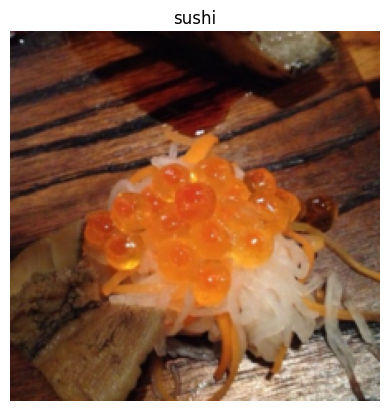

In [7]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis("off")

## 3. Replicating ViT

## 4. Equation 1: Split data into patches and creating the class, position and path embedding

* Input shape: $H\times{W}\times{C}$
* Output shape: ${N \times\left(P^{2} \cdot C\right)}$

* H = height
* W = width
* C = color channels
* P = patch size
* N = number of paches = (height * width) / p^2
* D = constant latent vector size = embedding dimension

### 4.1 Calculate input and output shapes by hand

In [8]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height * width) / (patch_size ** 2))
number_of_patches

196

In [9]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)
print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768)


### 4.2 Turning a single image into patches

(-0.5, 223.5, 223.5, -0.5)

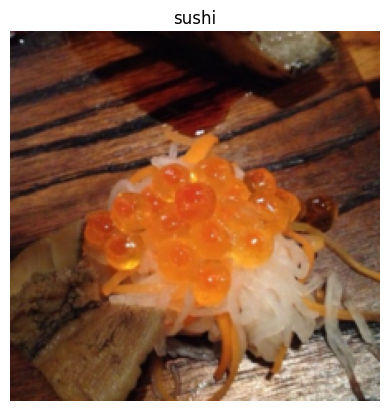

In [10]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis("off")

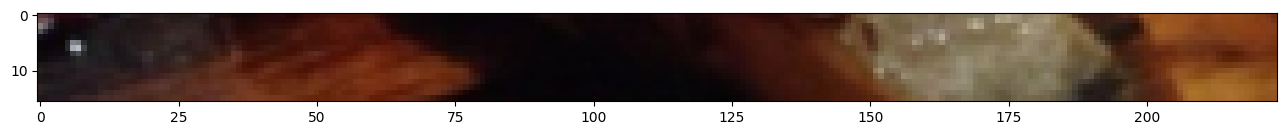

In [11]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0)
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

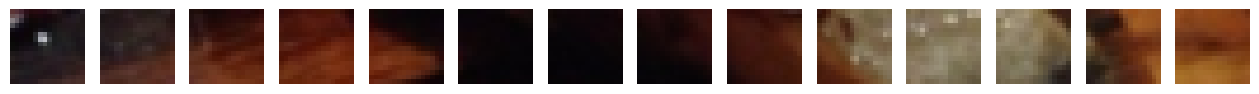

In [12]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
fig, axis = plt.subplots(nrows=1,
                         ncols=img_size // patch_size,
                         sharex=True,
                         sharey=True, figsize=(patch_size, patch_size))
for i, patch in enumerate(range(0, img_size, patch_size)):
  axis[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
  axis[i].set_xlabel(i+1)
  axis[i].set_xticks([])
  axis[i].set_yticks([])
  axis[i].axis("off")

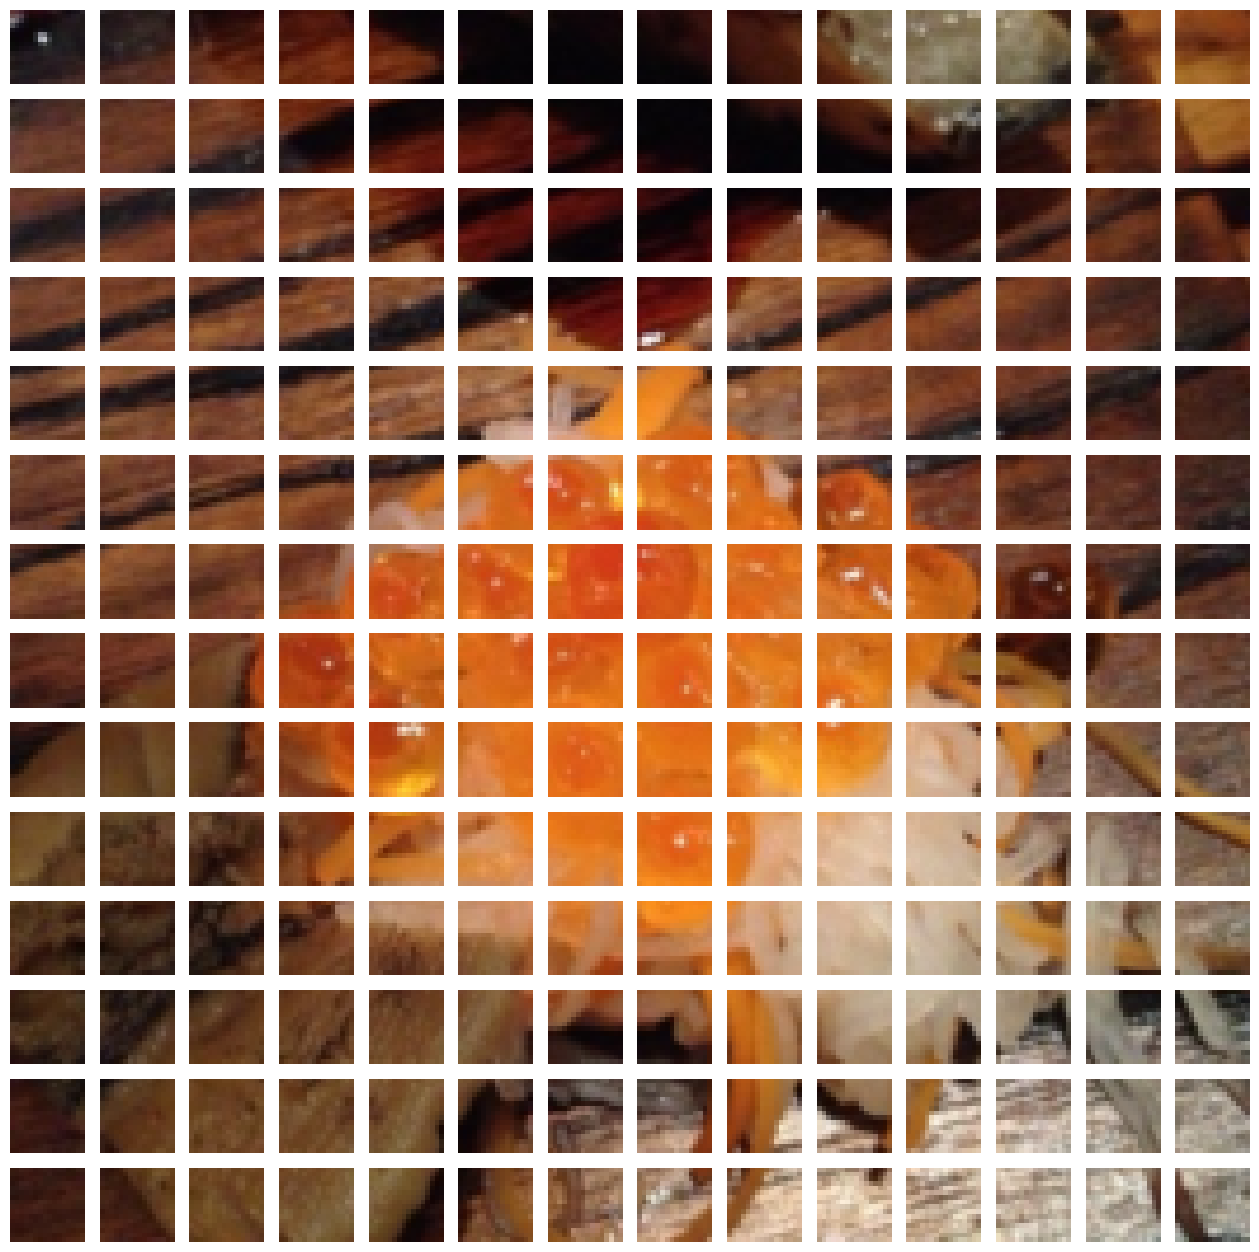

In [13]:
 # Setup code to plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"

fig, axis = plt.subplots(nrows=img_size // patch_size,
                         ncols=img_size // patch_size,
                         sharex=True,
                         sharey=True, figsize=(patch_size, patch_size))

for i, patch_row in enumerate(range(0, img_size, patch_size)):
  for j, patch_col in enumerate(range(0, img_size, patch_size)):
    axis[i][j].imshow(image_permuted[patch_row:patch_row + patch_size, patch_col:patch_col+patch_size, :])
    axis[i][j].set_xlabel(i+1)
    axis[i][j].set_xticks([])
    axis[i][j].set_yticks([])
    axis[i][j].axis("off")

### 4.3 Creating image patches and turning them into patch embeddings

In [15]:
# Create conv2ddd layer to turn image into patches of learnable feature maps (embedings)
from torch import nn

patch_size = 16
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(-0.5, 223.5, 223.5, -0.5)

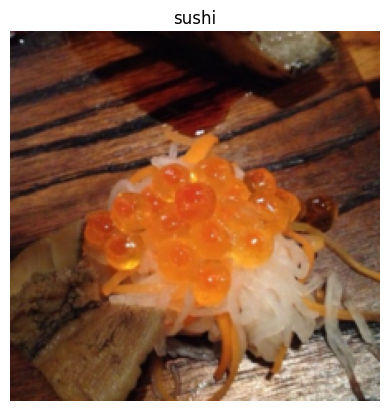

In [17]:
# View single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [18]:
# pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(dim=0))
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

Random indexs: [513, 386, 615, 378, 101]


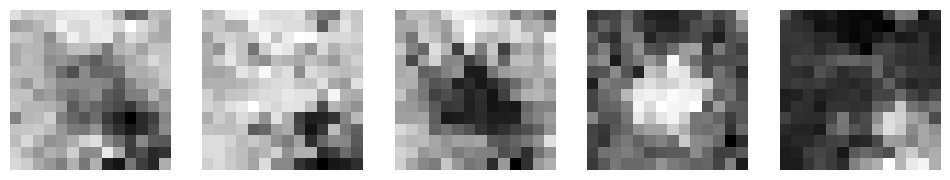

In [26]:
# plot random convolutionla feature maps (embeddings)

import random
random_indexs = random.sample(range(0, 758), k=5)
print(f"Random indexs: {random_indexs}")

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))
for i, idx in enumerate(random_indexs):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :]
  axs[i].imshow(image_conv_feature_map.detach().numpy().squeeze(), cmap=plt.cm.gray)
  axs[i].axis("off")


In [25]:
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map

tensor([[[ 0.1286,  0.1371,  0.0999,  0.0695,  0.0935, -0.0094, -0.0112,
          -0.0251,  0.0136,  0.3091,  0.4936,  0.3718,  0.1547,  0.1804],
         [ 0.2208,  0.1472,  0.0716, -0.0622,  0.0569,  0.0278, -0.0353,
           0.0021, -0.0245, -0.0192, -0.0330,  0.0669,  0.1031,  0.0748],
         [ 0.1086,  0.1825,  0.2104,  0.1024,  0.0436,  0.0017, -0.0748,
          -0.0452,  0.1883,  0.2490,  0.0419,  0.0867,  0.1110,  0.0888],
         [ 0.0985,  0.1421,  0.2095,  0.1356,  0.0630,  0.2504,  0.1233,
           0.1929,  0.1184,  0.1481,  0.2131,  0.1085,  0.1078,  0.0434],
         [ 0.1363,  0.1714,  0.2501,  0.3135,  0.2593,  0.3946,  0.3767,
           0.2884,  0.3902,  0.2344,  0.0965,  0.0350,  0.0846,  0.0909],
         [ 0.1347,  0.1193,  0.1557,  0.2179,  0.4010,  0.3528,  0.1980,
           0.2148,  0.2222,  0.2770,  0.2189,  0.1305,  0.1335,  0.1198],
         [ 0.2116,  0.1333,  0.1299,  0.2679,  0.2041,  0.2016,  0.1391,
           0.1724,  0.2691,  0.3718,  0.1982,

### 4.4 Flattening the patch embedding with torch.nn.Flatten()

In [29]:
flatten_layer = nn.Flatten(start_dim=2, end_dim=-1)
image_out_of_flat = flatten_layer(image_out_of_conv)
image_out_of_flat.permute(0, 2, 1).shape

torch.Size([1, 196, 768])